In [1]:
import torch
import torch.nn as nn
import tiktoken as tk
from torch.utils.data import DataLoader, Dataset

In [59]:
import urllib.request
import zipfile
import json
import os
from pathlib import Path
from typing import List, Dict, Tuple
import numpy as np
import time
from tqdm import tqdm

In [3]:
import sys
sys.path.append('/content/drive/My Drive/LLM/Notebooks')

In [4]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text)
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(tokens, tokenizer):
  token_list = tokens.squeeze(0).tolist()
  decoded = tokenizer.decode(token_list)
  return decoded

# **Dataset Preparation**

In [5]:
def download_and_load_file(file_path, url):
  if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
      text_data = response.read().decode("utf-8")
    with open(file_path, 'w', encoding='utf-8') as f:
      f.write(text_data)
  else:
    with open(file_path, 'r', encoding='utf-8') as f:
      text_data = f.read()
  with open(file_path, 'r') as f:
    data = json.load(f)
  return data

In [6]:
file_path = '/content/drive/My Drive/LLM/Data/instruction-data.json'
url = 'https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json'

data = download_and_load_file(file_path, url)
print("Total entries: ", len(data))

Total entries:  1100


In [7]:
#lets have a look at one of the entries to explore the dataset
print(data[50])

{'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [8]:
def format_entry(entry):
  instruction_text = (
      f"Below is the instruction that describes a task. Write an appropriate response to address the instruction. "
      f"\n\n### Instruction:\n{entry['instruction']}"
  )

  input_text = f"\n\n### Input:\n{entry['input']}" if entry['input'] else ""

  return instruction_text + input_text

In [9]:
print(f'Instruction template\n{format_entry(data[50])}')
print(f'\n\nResponse: {data[50]["output"]}')

Instruction template
Below is the instruction that describes a task. Write an appropriate response to address the instruction. 

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion


Response: The correct spelling is 'Occasion.'


In [10]:
def dataset_split(data: List[Dict], train_size: float, test_size: float) -> Tuple[List[Dict], List[Dict], List[Dict]]:
  train_data = data[:int(len(data) * train_size)]
  test_data = data[int(len(data) * train_size) : int(len(data) * (train_size + test_size))]
  val_data = data[int(len(data) * (train_size + test_size)):]
  return train_data, val_data, test_data

In [11]:
train_data, val_data, test_data = dataset_split(data, 0.85, 0.1)

In [12]:
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

Train data size: 935
Validation data size: 55
Test data size: 110


In [13]:
tokenizer = tk.get_encoding('gpt2')

In [14]:
#lets prepate instruction dataset
class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data
    self.entry_lst = []

    for entry in self.data:
      formatted_entry = format_entry(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      encoded_text = tokenizer.encode(formatted_entry + response_text)
      self.entry_lst.append(encoded_text)

  def __getitem__(self, idx):
    return self.entry_lst[idx]

  def __len__(self):
    return len(self.entry_lst)


In [15]:
#lets implement our custom collate fn to batch the data for dataloader
def custom_collate_fn(batch, allowed_max_length=1024, pad_token=50256, ignore_index=-100, device='cpu'):
  batch_max_length = max([len(item)+1 for item in batch])
  inputs_lst = []
  targets_lst = []
  for item in batch:
    new_item = item.copy()
    new_item += [pad_token]

    padded_item = new_item + [pad_token] * (batch_max_length - len(new_item))
    input = torch.tensor(padded_item[:-1])
    target = torch.tensor(padded_item[1:])

    mask = target == pad_token
    indices = torch.nonzero(mask).squeeze()
    if indices.numel() > 1:
      target[indices[1:]] = ignore_index

    #restricting input and target to max_length
    if allowed_max_length is not None:
      input = input[:allowed_max_length]
      target = target[:allowed_max_length]

    inputs_lst.append(input)
    targets_lst.append(target)

  inputs = torch.stack(inputs_lst).to(device)
  targets = torch.stack(targets_lst).to(device)

  return inputs, targets

In [16]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
from functools import partial

customized_collate_fn = partial(custom_collate_fn, allowed_max_length=1024, pad_token=50256, ignore_index=-100, device=device)

In [18]:
batch_size = 8
num_workers = 0

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=customized_collate_fn, drop_last=True, num_workers=num_workers)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=customized_collate_fn, drop_last=False, num_workers=num_workers)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=customized_collate_fn, drop_last=False, num_workers=num_workers)

In [19]:
for i,(x,y) in enumerate(train_loader):
  print(f"{x.shape}\t\t\t{y.shape}")
  if i>10:
    break

torch.Size([8, 62])			torch.Size([8, 62])
torch.Size([8, 77])			torch.Size([8, 77])
torch.Size([8, 74])			torch.Size([8, 74])
torch.Size([8, 69])			torch.Size([8, 69])
torch.Size([8, 66])			torch.Size([8, 66])
torch.Size([8, 73])			torch.Size([8, 73])
torch.Size([8, 81])			torch.Size([8, 81])
torch.Size([8, 68])			torch.Size([8, 68])
torch.Size([8, 63])			torch.Size([8, 63])
torch.Size([8, 76])			torch.Size([8, 76])
torch.Size([8, 63])			torch.Size([8, 63])
torch.Size([8, 69])			torch.Size([8, 69])


## **Initialize model with pretrained weights**

In [20]:
class MultiHeadAttention(nn.Module):
  def __init__(self, dim_in, dim_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    assert (dim_out % num_heads == 0), "dim_out must be divisible by num_heads"

    self.dim_out = dim_out # final merged context vector embedding size
    self.num_heads = num_heads
    self.head_dim = dim_out//num_heads # embedding size of context vector in single head
    self.w_query = torch.nn.Linear(dim_in, dim_out, bias=qkv_bias)
    self.w_key = torch.nn.Linear(dim_in, dim_out, bias=qkv_bias)
    self.w_value = torch.nn.Linear(dim_in, dim_out, bias=qkv_bias)
    self.out_proj = torch.nn.Linear(dim_out, dim_out) # transform merged context_vectors into similar dimension size vectors
    self.dropout = torch.nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    batch_size, num_tokens, dim_in = x.shape
    queries = self.w_query(x)
    keys = self.w_key(x)
    values = self.w_value(x)  #shape (batch_size, num_tokens, dim_out)

    queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim)
    keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)
    values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim) #shape (batch_size, num_tokens, num_heads, head_dim)

    queries = queries.transpose(1,2)
    keys = keys.transpose(1,2)
    values = values.transpose(1,2) #shape (batch_size, num_heads, num_tokens, head_dim)

    attention_scores = queries @ keys.transpose(2,3)
    attention_scores.masked_fill_(self.mask.bool()[:num_tokens,:num_tokens], -torch.inf)

    attention_weights = torch.softmax(attention_scores/keys.shape[-1]**0.5, dim=-1)
    attention_weights = self.dropout(attention_weights)

    context_vectors = (attention_weights @ values).transpose(1,2) #transposing axis 1,2  since we have to merge the context vectors by num_heads and head_dim, so required shape will now be (batch_size, num_tokens, num_heads, head_dim)
    context_vectors = context_vectors.contiguous().view(batch_size, num_tokens, self.dim_out)

    context_vectors = self.out_proj(context_vectors)

    return context_vectors

In [21]:
class LayerNorm(nn.Module):
  def __init__(self, emb_size):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_size))
    self.shift = nn.Parameter(torch.zeros(emb_size))

  def forward(self, x):
    mean = x.mean(keepdim=True, dim=-1)
    variance = x.var(keepdim=True, dim=-1, unbiased=False)
    norm_x = (x - mean)/torch.sqrt(variance + self.eps)
    return self.scale * norm_x + self.shift

In [22]:
class GeLU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x,3))
    ))

In [23]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_size'], 4 * cfg['emb_size']),
        GeLU(),
        nn.Linear(4 * cfg['emb_size'], cfg['emb_size'])
    )

  def forward(self, x):
    return self.layers(x)

In [24]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.mha = MultiHeadAttention(cfg['emb_size'], cfg['emb_size'], cfg['context_length'], cfg['drop_rate'], cfg['num_heads'], qkv_bias=cfg['qkv_bias'])
    self.layer_norm1 = LayerNorm(cfg['emb_size'])
    self.layer_norm2 = LayerNorm(cfg['emb_size'])
    self.ffn = FeedForward(cfg)
    self.dropout = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    shortcut = x
    x = self.layer_norm1(x)
    x = self.mha(x)
    x = self.dropout(x)
    x = x + shortcut

    shortcut = x
    x = self.layer_norm2(x)
    x = self.ffn(x)
    x = self.dropout(x)
    x = x + shortcut

    return x

In [25]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_emb_layer = nn.Embedding(cfg['vocab_size'], cfg['emb_size'])
    self.pos_emb_layer = nn.Embedding(cfg['context_length'], cfg['emb_size'])
    self.dropout_layer = nn.Dropout(cfg['drop_rate'])
    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['num_layers'])]
    )
    self.final_norm = LayerNorm(cfg['emb_size'])
    self.output_layer = nn.Linear(cfg['emb_size'], cfg['vocab_size'], bias=False)

  def forward(self, inp_tokens):
    batch_size, num_tokens = inp_tokens.shape
    token_emb = self.token_emb_layer(inp_tokens)
    pos_emb = self.pos_emb_layer(
        torch.arange(num_tokens, device=inp_tokens.device)
    )
    x = token_emb + pos_emb
    x = self.dropout_layer(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.output_layer(x)

    return logits

In [26]:
BASE_CONFIG = {
    'vocab_size': 50257,
    'context_length': 1024,
    'drop_rate': 0.0,
    'qkv_bias': True
}

model_configs = {
    'gpt2-small (124M)': {
        'emb_size':768,
        'num_heads':12,
        'num_layers':12,
    },
    'gpt2-medium (355M)': {
        'emb_size':1024,
        'num_heads':16,
        'num_layers':24,
    },
    'gpt2-large (774M)': {
        'emb_size':1280,
        'num_heads':20,
        'num_layers':36,
    },
    'gpt2-xl (1558M)': {
        'emb_size':1600,
        'num_heads':25,
        'num_layers':48,
    }
}

In [27]:
model_name = 'gpt2-medium (355M)'
model_size = model_name.split(' ')[-1].lstrip('(').rstrip(')')
BASE_CONFIG.update(model_configs[model_name])

In [28]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size=model_size, models_dir='gpt2')

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [29]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f'Shape mismatch. Left: {left.shape}. Right: {right.shape}')
  return torch.nn.Parameter(torch.tensor(right))

In [30]:
def load_parameters(gpt, params):
  gpt.token_emb_layer.weight = assign(gpt.token_emb_layer.weight, params['wte'])
  gpt.pos_emb_layer.weight = assign(gpt.pos_emb_layer.weight, params['wpe'])

  #transformer blocks' parameters loading
  for b in range(len(params['blocks'])):
    #each blocks' mha qkv weights
    q_w, k_w, v_w = np.split(
        params['blocks'][b]['attn']['c_attn']['w'], 3, axis=-1
    )
    gpt.trf_blocks[b].mha.w_query.weight = assign(
        gpt.trf_blocks[b].mha.w_query.weight, q_w.T
    )
    gpt.trf_blocks[b].mha.w_key.weight = assign(
        gpt.trf_blocks[b].mha.w_key.weight, k_w.T
    )
    gpt.trf_blocks[b].mha.w_value.weight = assign(
        gpt.trf_blocks[b].mha.w_value.weight, v_w.T
    )

    #each blocks' mha qkv bias
    q_b, k_b, v_b = np.split(
        params['blocks'][b]['attn']['c_attn']['b'], 3, axis=-1
    )
    gpt.trf_blocks[b].mha.w_query.bias = assign(
        gpt.trf_blocks[b].mha.w_query.bias, q_b
    )
    gpt.trf_blocks[b].mha.w_key.bias = assign(
        gpt.trf_blocks[b].mha.w_key.bias, k_b
    )
    gpt.trf_blocks[b].mha.w_value.bias = assign(
        gpt.trf_blocks[b].mha.w_value.bias, v_b
    )

    #each blocks' mha out_proj layer's weight and bias
    gpt.trf_blocks[b].mha.out_proj.weight = assign(
        gpt.trf_blocks[b].mha.out_proj.weight, params['blocks'][b]['attn']['c_proj']['w'].T
    )
    gpt.trf_blocks[b].mha.out_proj.bias = assign(
        gpt.trf_blocks[b].mha.out_proj.bias, params['blocks'][b]['attn']['c_proj']['b']
    )

    #each blocks' ff wieghts and biases
    gpt.trf_blocks[b].ffn.layers[0].weight = assign(
        gpt.trf_blocks[b].ffn.layers[0].weight, params['blocks'][b]['mlp']['c_fc']['w'].T
    )
    gpt.trf_blocks[b].ffn.layers[0].bias = assign(
        gpt.trf_blocks[b].ffn.layers[0].bias, params['blocks'][b]['mlp']['c_fc']['b']
    )
    gpt.trf_blocks[b].ffn.layers[2].weight = assign(
        gpt.trf_blocks[b].ffn.layers[2].weight, params['blocks'][b]['mlp']['c_proj']['w'].T
    )
    gpt.trf_blocks[b].ffn.layers[2].bias = assign(
        gpt.trf_blocks[b].ffn.layers[2].bias, params['blocks'][b]['mlp']['c_proj']['b']
    )

    #each blocks' layer_norms scale and shift
    gpt.trf_blocks[b].layer_norm1.scale = assign(
        gpt.trf_blocks[b].layer_norm1.scale, params['blocks'][b]['ln_1']['g']
    )
    gpt.trf_blocks[b].layer_norm1.shift = assign(
        gpt.trf_blocks[b].layer_norm1.shift, params['blocks'][b]['ln_1']['b']
    )
    gpt.trf_blocks[b].layer_norm2.scale = assign(
        gpt.trf_blocks[b].layer_norm2.scale, params['blocks'][b]['ln_2']['g']
    )
    gpt.trf_blocks[b].layer_norm2.shift = assign(
        gpt.trf_blocks[b].layer_norm2.shift, params['blocks'][b]['ln_2']['b']
    )

  #gpt's final_layer_norm
  gpt.final_norm.scale = assign(
        gpt.final_norm.scale, params['g']
  )
  gpt.final_norm.shift = assign(
        gpt.final_norm.shift, params['b']
  )
  gpt.output_layer.weight = assign(
      gpt.output_layer.weight, params['wte']
  )

In [31]:
def generate_text_tokens(model, inp_tokens, max_tokens, context_size):
  for _ in range(max_tokens):
    cropped_tokens = inp_tokens[:,-context_size:]
    with torch.no_grad():
      logits = model(cropped_tokens)

    logits = logits[:,-1,:]
    prob = torch.softmax(logits, dim=-1)
    token_id = torch.argmax(prob, dim=-1, keepdim=True)
    inp_tokens = torch.cat((inp_tokens, token_id), dim=1)

  return inp_tokens

In [32]:
def ce_batch_loss_calc(input_batch, target_batch, model, device):
  """
  ARGS
  input_batch: torch.tensor 2-D
  target_batch: torch.tensor 2-D
  model: GPTModel
  device: torch.device - 'cuda' or 'cpu'

  calculates cross-entropy loss for a batch
  """
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits_batch = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits_batch.flatten(0, 1), target_batch.flatten())

  return loss

In [33]:
def calc_loss_dataloader(loader, model, device, num_batches=None):
  """
  ARGS
  loader: dataloader
  model: GPTModel
  device: torch.device - 'cuda' or 'cpu'
  num_batches: integer

  calculates mean cross entropy loss across all the batches of the dataloader
  """
  total_loss = 0
  if len(loader) == 0:
    return float('nan')
  elif num_batches is None:
    num_batches = len(loader)
  elif num_batches < 0:
    num_batches = float('nan')
  else:
    num_batches = min(num_batches, len(loader))

  for i, (x, y) in enumerate(loader):
    if i < num_batches:
      loss = ce_batch_loss_calc(x, y, model, device)
      total_loss += loss.item()
    else:
      break

  return total_loss/num_batches

In [34]:
def train_model_simple(model, train_loader, val_loader, device, optimizer, epochs, eval_freq, eval_iter, start_context, tokenizer):
  train_loss_arr, val_loss_arr, track_tokens_seen = [], [], []
  global_step, tokens_seen = -1, 0

  for epoch in range(epochs):
    model.train()
    for x, y in train_loader:
      model.zero_grad()
      train_loss = ce_batch_loss_calc(x, y, model, device)
      train_loss.backward()
      optimizer.step()
      tokens_seen += x.numel()
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
        train_loss_arr.append(train_loss)
        val_loss_arr.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f'Train loss after epoch {epoch} (Step: {global_step}): {train_loss:.3f}')
        print(f'Val loss after epoch {epoch} (Step: {global_step}): {val_loss:.3f}')
        print(f'Number of tokens seen after epoch {epoch} (Step: {global_step})')

    generate_and_print_sample(model, start_context, tokenizer, device)

  return train_loss_arr, val_loss_arr, track_tokens_seen

In [35]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_dataloader(train_loader, model, device, eval_iter)
    val_loss = calc_loss_dataloader(val_loader, model, device, eval_iter)
  model.train()

  return train_loss, val_loss

In [36]:
def generate_and_print_sample(model, start_context, tokenizer, device):
  model.eval()
  context_size = model.trf_blocks[0].mha.mask.shape[0] ##model.pos_emb.shape[0]
  encoded_text = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    op_tokens = generate_text_tokens(model, encoded_text, max_tokens=50, context_size=context_size)
  decoded_text = token_ids_to_text(op_tokens, tokenizer)

  print(decoded_text.replace('\n',' '))
  model.train()

In [37]:
#generate fn with capabilities to control random of response
def generate(model, inp_tokens, context_size, max_tokens, temperature=0.0, top_k=None, eos_id=None):
  for i in range(max_tokens):
    cond_inp = inp_tokens[:,-context_size:]
    with torch.no_grad():
      logits = model(cond_inp)
    logits = logits[:,-1,:]

    if top_k is not None:
      top_logits, top_idx = torch.topk(logits, top_k)
      logits = torch.where(
          condition=logits<top_logits[:,-1],
          input=torch.tensor(float('-inf')),
          other=logits
      )

    if temperature > 0:
      scaled_logits = logits / temperature
      probs = torch.softmax(scaled_logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
    else:
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)

    if idx_next == eos_id:
      break

    inp_tokens = torch.cat((inp_tokens, idx_next), dim=1)

  return inp_tokens

In [38]:
gpt = GPTModel(BASE_CONFIG)

In [39]:
load_parameters(gpt, params)
gpt.eval()

GPTModel(
  (token_emb_layer): Embedding(50257, 1024)
  (pos_emb_layer): Embedding(1024, 1024)
  (dropout_layer): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_query): Linear(in_features=1024, out_features=1024, bias=True)
        (w_key): Linear(in_features=1024, out_features=1024, bias=True)
        (w_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GeLU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (mha): MultiHeadAttention(
 

In [40]:
temp_inp = format_entry(val_data[0])
output_token_ids = generate(
    model=gpt,
    inp_tokens=text_to_token_ids(text=temp_inp, tokenizer=tokenizer),
    context_size=BASE_CONFIG['context_length'],
    max_tokens=35,
    eos_id=50256
)

output_text = token_ids_to_text(output_token_ids, tokenizer)
print(temp_inp)
print("\n\n\n\n")
print(output_text[len(temp_inp):].strip())

Below is the instruction that describes a task. Write an appropriate response to address the instruction. 

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'





### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [41]:
#lets calculate the train loss and validation loss before we fine-tune the model
torch.manual_seed(123)
gpt.to(device)

with torch.no_grad():
  train_loss = calc_loss_dataloader(train_loader, gpt, device, num_batches=5)
  val_loss = calc_loss_dataloader(val_loader, gpt, device, num_batches=5)

print(f"Train loss: {train_loss}")
print(f"Validation loss: {val_loss}")

Train loss: 3.8755922317504883
Validation loss: 3.808723497390747


In [42]:
torch.manual_seed(123)

t0 = time.time()

epochs = 2
optimizer = torch.optim.AdamW(gpt.parameters(), lr=0.00005, weight_decay=0.1)

train_losses, val_losses, track_tokens_seen = train_model_simple(gpt, train_loader, val_loader, device, optimizer, epochs, eval_freq=5, eval_iter=5, start_context=format_entry(val_data[0]), tokenizer=tokenizer)

t1 = time.time()

exec_time = (t1 - t0)/60 # in minutes

print(f"Training completed in {exec_time} mins")

Train loss after epoch 0 (Step: 0): 2.766
Val loss after epoch 0 (Step: 0): 2.758
Number of tokens seen after epoch 0 (Step: 0)
Train loss after epoch 0 (Step: 5): 1.169
Val loss after epoch 0 (Step: 5): 1.094
Number of tokens seen after epoch 0 (Step: 5)
Train loss after epoch 0 (Step: 10): 0.863
Val loss after epoch 0 (Step: 10): 0.934
Number of tokens seen after epoch 0 (Step: 10)
Train loss after epoch 0 (Step: 15): 0.845
Val loss after epoch 0 (Step: 15): 0.897
Number of tokens seen after epoch 0 (Step: 15)
Train loss after epoch 0 (Step: 20): 0.773
Val loss after epoch 0 (Step: 20): 0.869
Number of tokens seen after epoch 0 (Step: 20)
Train loss after epoch 0 (Step: 25): 0.743
Val loss after epoch 0 (Step: 25): 0.852
Number of tokens seen after epoch 0 (Step: 25)
Train loss after epoch 0 (Step: 30): 0.790
Val loss after epoch 0 (Step: 30): 0.826
Number of tokens seen after epoch 0 (Step: 30)
Train loss after epoch 0 (Step: 35): 0.712
Val loss after epoch 0 (Step: 35): 0.801
Numbe

In [43]:
track_tokens_seen[-1]

130624

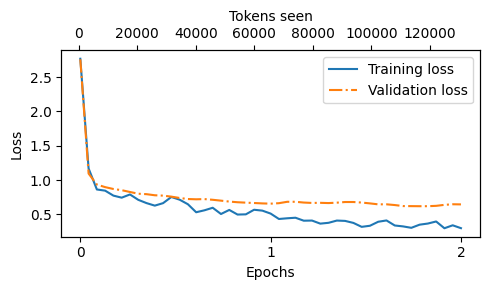

In [44]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5,3))
  ax1.plot(epochs_seen, train_losses, label='Training loss')
  ax1.plot(epochs_seen, val_losses, linestyle='-.', label='Validation loss')
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()

epochs_tensor = torch.linspace(0, epochs, len(train_losses))
plot_losses(
    epochs_tensor, track_tokens_seen,
    train_losses,
    val_losses
    )

In [55]:
#lets test the fine-tuned model on test data
for entry in test_data[:3]:
  formatted_entry = format_entry(entry)
  output_tokens = generate(
      model=gpt,
      inp_tokens=text_to_token_ids(formatted_entry, tokenizer).to(device),
      context_size=BASE_CONFIG['context_length'],
      max_tokens=256,
      eos_id=50256
  )
  output_text = token_ids_to_text(output_tokens, tokenizer)
  response_text = output_text[len(formatted_entry):].replace("### Response:",'').strip()
  print(formatted_entry)
  print(f"Correct Response: {entry['output']}")
  print(f'Model Response: {response_text}\n\n\n')


Below is the instruction that describes a task. Write an appropriate response to address the instruction. 

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.
Correct Response: The car is as fast as lightning.
Model Response: The car is as fast as a cheetah.



Below is the instruction that describes a task. Write an appropriate response to address the instruction. 

### Instruction:
What type of cloud is typically associated with thunderstorms?
Correct Response: The type of cloud typically associated with thunderstorms is cumulonimbus.
Model Response: A thunderstorm is a type of cumulus cloud that is formed when thunderstorms produce a dense, fast-moving, and intense updraft of air.



Below is the instruction that describes a task. Write an appropriate response to address the instruction. 

### Instruction:
Name the author of 'Pride and Prejudice'.
Correct Response: Jane Austen.
Model Response: The author of 'Pride and Prejudice' is Jane Austen.



In [57]:
def extract_and_save_responses(data, model, device, tokenizer):
  for i, entry in tqdm(enumerate(data), total=len(data)):
    formatted_entry = format_entry(entry)
    output_tokens = generate(
        model=model,
        inp_tokens=text_to_token_ids(formatted_entry, tokenizer).to(device),
        context_size=BASE_CONFIG['context_length'],
        max_tokens=256,
        eos_id=50256
    )
    output_text = token_ids_to_text(output_tokens, tokenizer)
    response_text = output_text[len(formatted_entry):].replace("### Response:",'').strip()

    data[i]['model_response'] = response_text

  with open('/content/drive/My Drive/LLM/Data/instruction-data-with-response.json','w') as file:
    json.dump(data, file)

In [60]:
extract_and_save_responses(test_data, gpt, device, tokenizer)

100%|██████████| 110/110 [01:21<00:00,  1.35it/s]
